In [1]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
# !git clone https://github.com/kteavery/transformers.git
# %pwd 
# %cd transformers

!pip install git+https://github.com/kteavery/transformers.git

# !pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

In [3]:
%cd '/content/drive/MyDrive/CS685/'

/content/drive/MyDrive/CS685


In [4]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config, AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset
from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [6]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )
md_df = pd.read_pickle("./med_dialogue_sample.pickle")
print(covid_dialog)

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-data_dir=.%2F


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'dialogue_url', 'dialogue_turns'],
        num_rows: 572
    })
})


In [7]:
cd_df = covid_dialog['train'].to_pandas()
md_df.drop(columns=["file_name"])
md_df = md_df[0:570]
print(len(md_df))
md_df.head()

570


,file_name,dialogue_id,dialogue_url,dialogue_turns
0,/content/drive/MyDrive/CS685/Medical-Dialogue-...,699,https://www.healthcaremagic.com/questions/What...,"{'speaker': [0, 1], 'utterance': ['What causes..."
1,/content/drive/MyDrive/CS685/Medical-Dialogue-...,1380,https://www.healthcaremagic.com/questions/Coul...,"{'speaker': [0, 1], 'utterance': ['Could frequ..."
2,/content/drive/MyDrive/CS685/Medical-Dialogue-...,1574,https://www.healthcaremagic.com/questions/What...,"{'speaker': [0, 1], 'utterance': ['What can ca..."
3,/content/drive/MyDrive/CS685/Medical-Dialogue-...,2049,https://www.healthcaremagic.com/questions/Can-...,"{'speaker': [0, 1], 'utterance': ['Can someone..."
4,/content/drive/MyDrive/CS685/Medical-Dialogue-...,2239,https://www.healthcaremagic.com/questions/Can-...,"{'speaker': [0, 1], 'utterance': ['Can respira..."


In [8]:
combined = pd.concat([cd_df, md_df])

qa_df = preprocessing(combined)
text = qa_df.text.copy()
print(len(qa_df))
qa_df.head()

1153


/content/data.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[<|patient|>I have cough with no travel histor...,"[Hello, I understand your concern. I just have...",[<|patient|>I have cough with no travel histor...
1,0,[<|patient|>I have cough with no travel histor...,"[Hi, I would recommend you take n-acetylcystei...",[<|patient|>I have cough with no travel histor...
2,1,[<|patient|>I have a little fever with no hist...,"[Hello, I can understand your concern.In my op...",[<|patient|>I have a little fever with no hist...
3,1,[<|patient|>I have a little fever with no hist...,"[Hi, yes, upload in this query only. I will se...",[<|patient|>I have a little fever with no hist...
4,1,[<|patient|>I have a little fever with no hist...,"[Hi, I can understand your concern. I have gon...",[<|patient|>I have a little fever with no hist...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


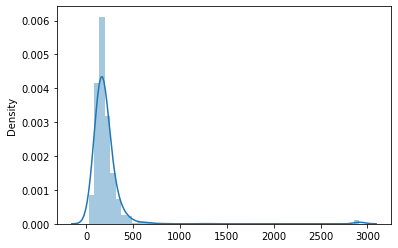

In [9]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [10]:
torch.cuda.empty_cache()

In [11]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
config = GPT2Config.from_pretrained("microsoft/DialoGPT-small")
tokenizer = GPT2TokenizerFast.from_pretrained("microsoft/DialoGPT-small")
tokenizer.add_tokens(["<|patient|>", "<|doctor|>"], special_tokens=True)
model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small", config=config)
print(model.config)


Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

GPT2Config {
  "_name_or_path": "microsoft/DialoGPT-small",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "conversational": {
      "max_length": 1000
    }
  },
  "transformers_version": "4.13.0.dev0",
  "use_cache": true,
  "vocab_size": 50257
}



In [12]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token

unique_vals = qa_df.id[len(qa_df)-1]

# Split into training and validation sets
train_size = int(0.75 * unique_vals)
val_size = int(0.125 * unique_vals)
test_size = unique_vals - train_size - val_size

train_split, val_split, test_split = split_data(qa_df, [train_size, val_size, test_size])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
test_split.reset_index(drop=True, inplace=True)

print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

train_dataset = GPT2Dataset(train_split, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768)
test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768, padding=False)

     id  ...                                               text
0   963  ...  [<|patient|>What is the suggested medicine for...
1   877  ...  [<|patient|>What causes problem problem in bre...
2   342  ...  [<|patient|>If I'm not sure if I have allergie...
3  1040  ...  [<|patient|>What could itchy small firm white ...
4   881  ...  [<|patient|>Suggest medication for sore throat...

[5 rows x 4 columns]
length of dataset: 1141
  855 training samples
  142 validation samples
  144 test samples


In [13]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [14]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cpu


In [15]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:

# device = torch.device("cuda")
# model.cuda()

# Set the seed value all over the place to make this reproducible.
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

Embedding(50259, 768)

In [35]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [36]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [37]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [38]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        b_prefix_masks = batch[3].to(device)
        # print(b_input_ids)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          prefix_mask = b_prefix_masks,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            # print(type(b_input_ids[0]))
            sample_outputs = model.generate( #b_input_ids[0],
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 50,
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        b_prefix_masks = batch[3].to(device)

        with torch.no_grad():        

            outputs  = model(b_input_ids, 
                             prefix_mask = b_prefix_masks,
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  

            if step % 2 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

              # print(b_input_ids[0])
              # print(type(b_input_ids[0]))
              sample_outputs = model.generate(
                                    # b_input_ids[0][b_input_ids[0] != 50256],
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 50,
                                    max_length = 200,
                                    top_p=0.95, 
                                    #num_return_sequences=1
                                )
              for i, sample_output in enumerate(sample_outputs):
                    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 1.9904370307922363.   Elapsed: 0:01:42.
0: :, 10,1,10,1,5,1,1,2,4,1,1,4,2,4,1,2,5,1,1,2,3,2,1,5,1,3,3,1,3,4,1,2,1,4,1,3,1,3,3,3,4,1,3,1,1,1,3,1,3,4,1,3,1,1,3,3,2,2,1,3,1,1,1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 0.852008044719696.   Elapsed: 0:03:24.
0: It is also important that you are patient the following pregnancy if you need your doctor's permission. There is no right way  i think. However, I hope you find the cure, ://www.Ask Dr.Pneumonia.    ://     ://www.healthtap.         Could you please text chat with me?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 1.660274624824524.   Elapsed: 0:05:06.
0: If you have asthma then should you not be worried about running a runny nose or runny nose, or what else is causing it?My doctor said if I have asthma then should I not be worried about running a runny nose or runny nose. I am getting worried at the moment. Please advise. My doctor gave me a runny nose and a running nose and a cough to make sure I was a natural health attack. He said I was suffering from an allergic reaction. I have been having an allergic reaction and now I have a fever, I have to get the bronchial drip (cold) and I get the flu with the shortness of breath to make it subside. I had an asthma attack on April April 11, and have been coughing for the past 3 days. It was very high pitched and heavy and I have had a slight fever since March 14. I have been feeling worse. I was just a bit upset that I couldn t hear what I could


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 1.2083826065063477.   Elapsed: 0:06:48.
0: What causes sore throat and sore cheek with white spots in it? My friend had a fever in the last week, and this week it is getting worse. He is sick now too. He has to start taking pain reliever. He is going to get him tested to determine his diagnosis. Hello Doctor,The temperature of your throat with white spots appear to be low.You should check out your throat which indicates this problem as well as you should consult a GP, so that you can get the virus.If symptoms develop and the virus is contagious then it will be unlikely to cure your condition.Call a doctor immediately, but don't worry, but if the viral virus has spread or spread it is usually not a serious disease but has a chance to produce the virus.In brief: Symptoms include severe cough, swelling of teeth, congestion, shortness of breath, a weak cough, pain in abdominal pain and shortness of breath.In brief:1. Do not worry about getting tested

  Aver

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 0.669592559337616.   Elapsed: 0:01:40.
0: Suggest remedy for cough during night after getting some sleep from a pillow?Hi, I have been coughing up tonsils and my throat is hurting alot. So hard to breath for some reason. Last night I woke up on the bed with this cough and was coughing up tonsils and that was the next night. After about 4:30 or 5-5 hours I started feeling a little sore and I had to take a deep breath. Now it's stuck there. I have been coughing and spitting up tonsils for the last 3 nights... I am a bit stiff as well... I have minor body aches but it doesn't hurt in general but itchy feeling. Maybe some minor chest pains or other problems. Last night I started coughing up tonsils on my bed and my throat was sore and it was still going, I have slight coughs, and sometimes has been spitting up tonsils. I also have a little sore throat. I'm trying to sleep with my hands being loose or


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 0.6224420666694641.   Elapsed: 0:03:21.
0: Can the corona virus spread as a result of airborne coronavirus?If yes, what do I do?Will the corona virus spread as a result of airborne coronavirus? If yes, what do I do? Coronavirus infected person has respiratory infection as the corona virus has spread. Coronavirus infected person has respiratory infection as the coronavirus has spread. Coronavirus infected person has respiratory infection as the corona virus has spread. Also, your symptoms include:  Coronavirus-infection, common cold, viral dry cough.  Use your medical care management.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 0.8772316575050354.   Elapsed: 0:05:03.
0: What causes a headache when treating chest pains after trying to sleep for 2 years?I’m 5 months old and have had four chest pains (there has been a few coughs which involved) and sometimes I cough up some strange stuff when I have sleep problems like a very slight cold on. I have tried yoga but I have not gotten much sleep this morning and the last 4-5 months have been worrying.I’m 5 months old and have had four chest pains (there has been a few coughs which involved) and sometimes I cough up some strange stuff when I have sleep problems like a very slight cold on. I have tried yoga but not got much sleep this morning and the last 4-5 months have been worrying. In brief:         It can be an infection as in a strep throat.      Usually if you have a strep throat infection then you should consult a physician or get some sleep


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 2.2834413051605225.   Elapsed: 0:06:45.
0: What causes the swelling of my chest and back and sore?Hi! I just want to know could the swelling of my heart be due to the flu or am I having trouble breathing with breathing?Hi! I just want to know could the swelling on my chest and back be due to the flu or am I having trouble breathing with breathing? It is because it is related to the flu.The swelling is due to a inflammation in the heart muscle, not due to the virus.I don't think you have a fever, because there is no swelling on the heart.Do you have any sore throat? I feel like your chest pain and back pain might be related to the flu.You may have a sore throat. You may have a fever with painfull discharge and discharge of the heart.I have minor coughs that show heart palpitations.Chest pain is mostly due to a virus.You need medical supervision.

  Average training loss: 0.94
  Training epoch took: 0:07:16

Running Validation...
  Validation Loss: 0.93
  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 0.4403292238712311.   Elapsed: 0:01:38.
0: Can someone please tell me what symptoms I was diagnosed with in Feb 2010 for the last one week? I am 15 year old female and in the last couple of weeks have been having horrible runny nose and sneezing and have been having horrible bouts of the flu ever since. I have had a really bad day this past weekend and this is so much I have to be careful of what to do, I have been really sick since this weekend?Is the flu now the common cold or is it more of a seasonal thing or what? Hello,Welcome to ‘Ask A Doctor’ service.I have reviewed your query and here is my advice.I went through your query and understand your concern.Yes, I would have checked your temperature/body/blood pressure/tonsilliness.So, I would have suggested you to go for the flu test, followed by objective test (complete hemogram).Hope I have answered your query. Let me know if I can assist


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 1.0683822631835938.   Elapsed: 0:03:20.
0: How effective amalu karishta suticasana and other drugs with low safety threshold for respiratory problem?I have been having a very difficult and troubling time breathing with no chest congestion for nearly 4.5 months now. I have been taking medicine (Adiprazole, Saliva and Miracast twice), with no side effects other than a cough. I am taking 1 tab Nucali, 15mg of Vati 2 mg of Pravala and 100mg of Tab Alu to be taken once a day. This is one month of the cycle for me. I am feeling as though it isn t going away. Thank you,Dr. Kaushalu.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 0.579039990901947.   Elapsed: 0:05:00.
0: Suggest a treatment for cold and coughHi. I m not feeling well and i started getting some cold and coughy. It s now morning and I feel a bit better but it keeps getting better like when I was a child. Is there any medicine to combat the cough? Hi there, there is no such thing as a fever, but it is possible that you will develop cold and cough with the cough. There are many kinds of medicine like this. In case, one would think of avoiding them is one's best option. I would also recommend to avoid triggers like cold, cough, cold or black pepper. Keep you hydrated for the duration of time. These are natural home remedies and they do not have to be taken in the morning. Also keep yourself hydrated to get relief. Remember the best thing is to use warm salt water and keep yourself warm to an effective level of 101 degrees Celsius and keep your feet separated from the air and the cold. It also helps to


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 0.828180730342865.   Elapsed: 0:06:44.
0: What is the reason for cough and pain when you cough hard?I am suffering from cough and pain when I cough hard. I also feel my chest is hurting sometimes. My breath feels like I am starting having trouble breathing then goes back into normal and makes my chest very sore. I also have a strange feeling in my throat. My chest feels a bit weird and has a hard time breathing. I take my Zinc pill and it doesn t seem to do much. I also feel my chest pain. I also have an odd sensation in my throat, sometimes it makes my throat very sore. My throat is also a bit weird and has a hard time breathing. I take my Zinc pill and it dosent seem to do much. I also take my Zinc pill and it makes my throat very sore. I also take my Zinc pill sometimes I take it 3 times in a day. I take my Zinc pill for a month. I still have a slight headache. I am

  Average training loss: 0.77
  Training epoch took: 0:07:14

Running Validation...
 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 1.3939930200576782.   Elapsed: 0:01:38.
0: How can asthma be treated with cough syrup?Hi doctor, I had cough syrup in April and today I started coughing very hard, throat is swollen and it hurts so much to breath. Now it is getting worse and I have a cough syrup. I take advil and ibuprofen but I also take levocetirizine Hello.Thank you for asking at HCM.From your history it seems that you are suffering from a chronic upper respiratory tract infection (common cold). This presents with very frequent coughs and mucus membranes on both sides of your throat.I would like to know your age, profession, profession, or any condition which might present with such symptoms. I would suggest you to consult an Allergist and/or psychiatrist for proper management. In my opinion, you should take Levocetirizine 10 mg once a day for at least 2 weeks. I would also suggest you a Spirometry test. If your symptoms are not improved I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 0.5210102796554565.   Elapsed: 0:03:21.
0: Is severe chest pain more common with upper respiratory infection or asthma?I had a chest xray which showed a mass on the right side of my throat, with a white spot on the right side of my throat. It looked like a phlegm to me. I also have asthma. HI, thanks for using healthcare magicIt is a viral upper respiratory infection and a person sees the doctor (call first) if the chest xray is clear.But, in my personal practice, the patient has a chest Xray which can be seen by a doctor (call first) and then antibiotics (antibiotics, decongestants, bronchodilators) which are usually a good measure for a person with asthma. (depending on the patient's asthma).


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 0.30793988704681396.   Elapsed: 0:05:05.
0: Is sore throat normal?Hi My throat is a bit sore I had about 30 Celsius last night and this morning felt like my throat was aching. I have also had a headache for about an hour. Could this all be due to allergies or common cold? I did some sleep and it seems like something is stuck in my throat. I also have cough so I'm worried that it may have been from all the dust I got while I was sleeping. Hello,Steam inhalation could indicate upper respiratory tract infection or upper respiratory tract infection.You should seek medical attention for thorough checkup if possible.You may need broncho-constriction (ICS) to get rid of this sore throat, along with thorough chest x-ray if diagnosed.You should also go for thorough blood investigation if known COVID-19 contact you.Hope this helps. Feel free to ask.If you have additional questions or follow up questions,you should go for a full round of self evaluation.Should


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 0.7683619260787964.   Elapsed: 0:06:48.
0: What causes dry cough and sore throat?Hi, I am having a dry cough for one week, I was thinking it might be a bacterial infection which is causing me discomfort. What medicine is best for my symptoms? I have pneumonia and have had a sore throat and a slightly sore throat for months. I have taken medicine for years as well as various cough suppressants. My doctor gave me cough syrup for 2 weeks for one week and gave me medicine for the other 3 days...after taking 2 tabs of cough suppressants I began to get the headache (maximum 3-4 hour). My left ear is quite clear. What can I do? I went to the emergency room 2 nights ago and they gave me medicine for a very minor headache. They said it would go away. I am still not using either remedy. I still have a sore throat (maximum four hours) and a bit of burning sensation inside my throat. Could the phlegm be there for awhile? I am just worried

  Average training loss: 0

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    428. Loss: 0.5558760762214661.   Elapsed: 0:01:37.
0: I have chills, breathing problems and cough with white phlegm. Could it be Coronavirus infection?Hello doctor,Last night I was getting chills, feeling more cold than usual and lightheaded and a lot of burping. Maybe like every 30 minutes or less or so feel more chills running down my body and chest feeling bit weird like I am starting having trouble breathing then goes back to normal and repeats, with weird feeling like chills down my left and right lungs or left and right upper chest. Also, my heart was pumping fast. Also, some minor coughs were there since seven days ago, still here. I have white mucus and have not gotten yellow yet.I took medicines yesterday but today I got severe cold and flu medicine with a pain reliever, the chills did not go away. Then today, I called the doctor on the phone and told him what happen last night and the same thing happened this morning too. I had minor coughs


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    428. Loss: 0.7292654514312744.   Elapsed: 0:03:19.
0: How to get rid of asthma,cough,body pain?Hi I am a 66 year old female non smoker non smoker. I have asthma but have been unsuccessful at my job as a consultant and now I have to rely on my inhalors to keep me down. My body hurts and tired when I swallow. I have not been able to get a good sleep for about 2 days now. I was thinking of moving to New England where I live and would have to have at least one or two meetings with the doctor. Hi thereThanks for using Healthcaremagic.As you are a smoker and have been in the medical field for over 70 years you may get asthma attack in just one day. So you have a good asthma control day.Avoid smoking and meeting your doctor in person.Ok and take care.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    428. Loss: 0.47676485776901245.   Elapsed: 0:05:01.
0: Will I ever have kids as my kids are too small to carry a full pupper? Will my kids ever have kids as my kids are too small to carry a full pupper? Will I ever have kids as my kids are too small to carry a full pupper? In brief:   Kids, you will definitely experience difficulty with growing and will have difficulty with controlling pupper.    In large pupper infests the kids and adults of all varieties of small children are at greater risk. It is a good idea to protect your kids and your kids. We are here for you. We are here for you. :)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    428. Loss: 0.38917097449302673.   Elapsed: 0:06:40.
0: Should I take extra vitamin C, or tab Levofloxacin for the flu shot?Should I take extra vitamin C, or tab Levofloxacin for the flu shot? TAKE IT NOW rather than wait to see symptoms.

  Average training loss: 0.51
  Training epoch took: 0:07:08

Running Validation...
  Validation Loss: 0.99
  Validation took: 0:00:22

Training complete!
Total training took 0:38:04 (h:mm:ss)


In [21]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.50,1.09,0:07:23,0:00:23
2,1.04,0.95,0:07:24,0:00:23
3,0.83,0.85,0:07:24,0:00:23
4,0.67,0.83,0:07:21,0:00:23
5,0.56,0.84,0:07:23,0:00:23
6,0.46,0.86,0:07:25,0:00:23


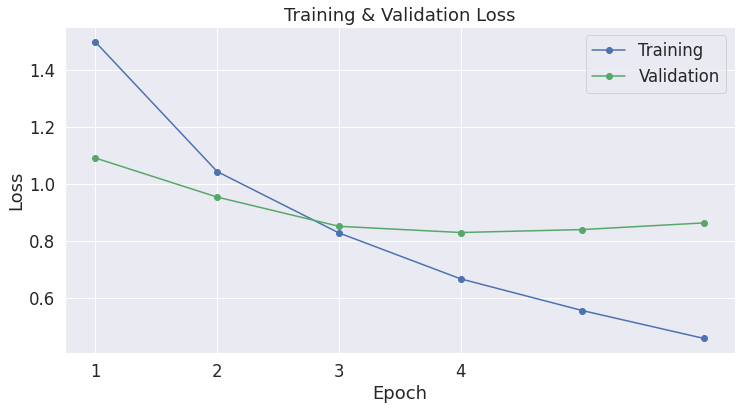

In [22]:
loss_curves(df_stats)

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [24]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './models/prefix0/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./models/prefix0/


('./models/prefix0/tokenizer_config.json',
 './models/prefix0/special_tokens_map.json',
 './models/prefix0/vocab.json',
 './models/prefix0/merges.txt',
 './models/prefix0/added_tokens.json',
 './models/prefix0/tokenizer.json')

In [17]:
tokenizer = GPT2TokenizerFast.from_pretrained("models/prefix1")
model = GPT2LMHeadModel.from_pretrained("models/prefix1")
model.to(device)

OSError: ignored

In [ ]:
model = model.to('cpu')
rougeL = []
rougeLsum = []
rouge1 = []
rouge2 = []

test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768, padding=False)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768, padding=False)

f = open('prefix.csv','w')
f.write("input, prediction, ground\n")

for i, encoder_input in enumerate(val_dataset.input_ids):
    # encoder_input = encoder_input[encoder_input != 50256]
    encoder_input = torch.reshape(encoder_input[0:-1], (1, -1))
    # print(encoder_input)

    # predicted = model.generate(encoder_input, max_length=1000, min_length=50, return_dict=True)
    predicted = model.generate(encoder_input,
                              do_sample=True,   
                              top_k=50, 
                              # beam=5,
                              min_length = 50,
                              max_length = 1000,
                              top_p=0.95, 
                              return_dict=True
                              )
    
    decoded_input = tokenizer.decode(encoder_input[0], skip_special_tokens=True)
    decoded_prediction = tokenizer.decode(predicted[:, encoder_input.shape[-1]:][0], skip_special_tokens=True)
    decoded_ground = tokenizer.decode(test_dataset.decoder_ids[i], skip_special_tokens=True)
    
    # print("input: ")
    print(decoded_input)
    # print("prediction: ")
    print(decoded_prediction)
    # print("ground: ")
    print(decoded_ground)
    print("\n")

    row = "[" + decoded_input.replace("\n", "") + "], [" + decoded_prediction.replace("\n", "") + "], [" + decoded_ground.replace("\n", "") + "]\n"
    f.write(row)

    rouge_dict = rouge(decoded_prediction, decoded_ground)
    rougeL.append(rouge_dict["rougeL"])
    rougeLsum.append(rouge_dict["rougeLsum"])
    rouge1.append(rouge_dict["rouge1"])
    rouge2.append(rouge_dict["rouge2"])

f.close()

avg_rougeL_p = sum([rougeL[i].precision for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_r = sum([rougeL[i].recall for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_f = sum([rougeL[i].fmeasure for i in range(len(rougeL))])/len(rougeL)

avg_rougeLsum_p = sum([rougeLsum[i].precision for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_r = sum([rougeLsum[i].recall for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_f = sum([rougeLsum[i].fmeasure for i in range(len(rougeLsum))])/len(rougeLsum)

avg_rouge1_p = sum([rouge1[i].precision for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_r = sum([rouge1[i].recall for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_f = sum([rouge1[i].fmeasure for i in range(len(rouge1))])/len(rouge1)

avg_rouge2_p = sum([rouge2[i].precision for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_r = sum([rouge2[i].recall for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_f = sum([rouge2[i].fmeasure for i in range(len(rouge2))])/len(rouge2)

print("RougeL - precision: " + str(avg_rougeL_p) + ", recall: " + str(avg_rougeL_r) + ", fmeasure: " + str(avg_rougeL_f))
print("RougeLsum - precision: " + str(avg_rougeLsum_r) + ", recall: " + str(avg_rougeLsum_r) + ", fmeasure: " + str(avg_rougeLsum_f))
print("Rouge1 - precision: " + str(avg_rouge1_p) + ", recall: " + str(avg_rouge1_r) + ", fmeasure: " + str(avg_rouge1_f))
print("Rouge2 - precision: " + str(avg_rouge2_p) + ", recall: " + str(avg_rouge2_r) + ", fmeasure: " + str(avg_rouge2_f))

In [ ]:
model = model.to('cpu')
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      print("How well did I answer the question? (See the five-point scale in the readme.)")
      input("Answer: ")
      print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
      input("Answer: ")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, min_length=50, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

In [ ]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different